# Process "Company Skills for Success" Question Using a LLM

Andrew Weng, 12/30/2024

We are going to use a mixed LLM-Python approach to solve the problem of "user text categorization."

This problem can be decomposed into five steps:

1. Pre-process (LLM1)
 - Each user provides up to three keywords as a string. These keywords need to be normalized and stored in a large list of individual keywords for the next stage.
2. Define categories (LLM2)
 - With the list of keywords, find the best set of categories to describe the keywords
3. Assign categories (LLM3)
 - For each keyword, assign it to a category. Be careful about how to handle exceptions (e.g., a keyword that doesn't seem to belog into any particular category.)
4. Count occurences (Python)
 - Within each category, sum up the total number of keywords. 
5. Visualize the results (Python)

In [1]:
import os
import time

current_folder = os.path.basename(os.getcwd())
if current_folder == 'notebooks':
    root_path = os.path.dirname(os.path.abspath(''))
    os.chdir(root_path)

from src.analyst import Analyst
from src.plotter import Plotter
from src.llm import LLM

from collections import defaultdict

import pickle
from pprint import pprint

from IPython import get_ipython
# Automatically reload all modules every time a line of code is executed
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

# Initialize our helper classes

In [2]:
analyst = Analyst()
analyst.load_data()
analyst.build_respondents_list()

plotter = Plotter()
llm = LLM()

# Fetch the relevant dataset to analyze

In [3]:
working_list = [] # includes unemployed but previously working
working_and_recruiting_list = [] # those who are working and participate in recruiting
student_list = []

for respondent in analyst.respondents_list:

    if respondent.is_working or respondent.is_unemployed:

        working_list.append(respondent)

        if respondent.company['role_level'] in ['Senior', 'Expert', 'Manager', 'Director/VP', 'Executive']:
            working_and_recruiting_list.append(respondent)

    if respondent.is_student:
        student_list.append(respondent)

print(f'Number of working respondents: {len(working_list)}')
print(f'Number of working respondents who also participate in recruiting: {len(working_and_recruiting_list)}')
print(f'Number of student respondents: {len(student_list)}')

Number of working respondents: 937
Number of working respondents who also participate in recruiting: 487
Number of student respondents: 86


In [5]:
question = dict()
question['tag'] = 'company_skills_top_for_success'
question['question'] = "In your opinion, what are the top skills that contributed to your success?"
question['categories'] = []
question['data'] = analyst.summarize_company_skills(working_and_recruiting_list)\
    ['top_skills_for_success_list']
len(question['data'])

414

# Pre-process the user response

Interpret the delimiters

In [6]:
keyword_list = []

for i, string_of_list in enumerate(question['data']):
    print(f"Processing response {i+1} of {len(question['data'])}")
    list_of_strings = llm.delimit_string_of_list(string_of_list)
    print(f'--> {list_of_strings}\n')
    keyword_list.extend(list_of_strings)

# Assemble and cache the list
print(keyword_list)
timestamp = time.strftime('%Y%m%d_%H%M%S')
with open(f'data/strlist_{question['tag']}_recruiters_{timestamp}.pkl', 'wb') as f:
    pickle.dump(keyword_list, f)

Processing response 1 of 414
--> ['PhD on the same class of materials as start up', 'ability to be adaptable and troubleshoot', 'strong network']

Processing response 2 of 414
--> []

Processing response 3 of 414
--> ['growth mindset', 'communication', 'more practicing']

Processing response 4 of 414
--> ['learning']

Processing response 5 of 414
--> ['Knowledge', 'Problem Solving Skills', 'Innovative Thinking']

Processing response 6 of 414
--> ['Excel', 'Powerpoint', 'Quick Comprehension']

Processing response 7 of 414
--> ['Continuous learning', 'Diligence', 'Marketing']

Processing response 8 of 414
--> ['planning skills', 'mathematical', 'people skills']

Processing response 9 of 414
--> ['Communication', 'product knowledge', 'self-motivation']

Processing response 10 of 414
--> ['communication', 'depth of knowledge', 'consulting experience']

Processing response 11 of 414
--> ['Communication']

Processing response 12 of 414
--> ['Energy Engineering', 'BMS', 'Electrical']

Process

# Define categories

In [9]:
if question['categories'] == []:

    categories = llm.define_categories(question['question'], keyword_list,
                                   num_categories=20)

    category_list = []
    for category in categories['categories']:
        category_list.append(category['name'])
else:
    category_list = question['categories']

pprint(category_list)

['Battery / Electrochemistry Knowledge',
 'Materials Science / Chemistry / Solid State Chemistry',
 'Programming / Coding / Data Analysis',
 'Communication / Presentation / Public Speaking',
 'Leadership / Management / Team Management',
 'Problem-Solving / Critical Thinking / Analytical Thinking',
 'Adaptability / Flexibility / Resilience',
 'Hard Work / Persistence / Tenacity / Grit',
 'Curiosity / Willingness to Learn / Continuous Learning',
 'Strategic Thinking / Vision',
 'Experience / Hands-on Skills',
 'Engineering Skills / Fundamentals',
 'Marketing / Sales / Business Development',
 'Technical Skills - Specific Domains',
 'Interdisciplinary / Cross-functional Knowledge',
 'Creativity / Innovation / Innovative Thinking',
 'Analytical Tools / Software Skills',
 'Business Acumen / Commercial Understanding',
 'Networking / Relationship Building',
 'Personal Attributes (Passion / Motivation / Ambition etc.)']


# Assign categories

Process one keyword at a time!

In [10]:
content_list = []
other_list = []
fail_list = []

for i, keyword in enumerate(keyword_list):

    print(f"Processing response: '{keyword}' ({i+1} of {len(keyword_list)})...")

    try:
        output = llm.classify_user_response(category_list, keyword,
                                            model='gpt-4o')
    except: # JSON output fails
        fail_list.append(keyword)
        continue

    if output['result']['category'] in category_list:
        content_list.append(output)
    else:
        other_list.append(output)

Processing response: 'PhD on the same class of materials as start up' (1 of 1101)...
Processing response: 'ability to be adaptable and troubleshoot' (2 of 1101)...
Processing response: 'strong network' (3 of 1101)...
Processing response: 'growth mindset' (4 of 1101)...
Processing response: 'communication' (5 of 1101)...
Processing response: 'more practicing' (6 of 1101)...
Processing response: 'learning' (7 of 1101)...
Processing response: 'Knowledge' (8 of 1101)...
Processing response: 'Problem Solving Skills' (9 of 1101)...
Processing response: 'Innovative Thinking' (10 of 1101)...
Processing response: 'Excel' (11 of 1101)...
Processing response: 'Powerpoint' (12 of 1101)...
Processing response: 'Quick Comprehension' (13 of 1101)...
Processing response: 'Continuous learning' (14 of 1101)...
Processing response: 'Diligence' (15 of 1101)...
Processing response: 'Marketing' (16 of 1101)...
Processing response: 'planning skills' (17 of 1101)...
Processing response: 'mathematical' (18 of 

In [11]:
print(len(other_list))

75


In [12]:
other_list

[{'result': {'response_text': 'Knowledge', 'category': 'Other'}},
 {'result': {'response_text': 'Knowledge', 'category': 'Other'}},
 {'result': {'response_text': 'Energy', 'category': 'Other'}},
 {'result': {'response_text': 'attention', 'category': 'Other'}},
 {'result': {'response_text': 'efficiency', 'category': 'Other'}},
 {'result': {'response_text': 'Strategic Sourcing and Supplier Management',
   'category': 'Other'}},
 {'result': {'response_text': 'Risk Management', 'category': 'Other'}},
 {'result': {'response_text': 'Fundamental understanding',
   'category': 'Other'}},
 {'result': {'response_text': 'endurance', 'category': 'Other'}},
 {'result': {'response_text': 'research 1', 'category': 'Other'}},
 {'result': {'response_text': 'languages 3', 'category': 'Other'}},
 {'result': {'response_text': 'Rivian Startup model', 'category': 'Other'}},
 {'result': {'response_text': 'Luck', 'category': 'Other'}},
 {'result': {'response_text': 'energy', 'category': 'Other'}},
 {'result':

In [13]:
print(len(fail_list))

0


## Assembly dictionary for plotting and a 'collection' dictionary

The 'collection' is a reference for which keywords got sorted into which categories.

In [14]:

collection = defaultdict(list)
counter    = defaultdict(int)

for content in content_list:

    category = content['result']['category']
    response = content['result']['response_text']
    counter[category] += 1
    collection[category].append(response)

counter['_tot_'] = len(question['data'])
counter

defaultdict(int,
            {'Materials Science / Chemistry / Solid State Chemistry': 42,
             'Adaptability / Flexibility / Resilience': 58,
             'Networking / Relationship Building': 55,
             'Curiosity / Willingness to Learn / Continuous Learning': 104,
             'Communication / Presentation / Public Speaking': 88,
             'Experience / Hands-on Skills': 52,
             'Problem-Solving / Critical Thinking / Analytical Thinking': 95,
             'Creativity / Innovation / Innovative Thinking': 31,
             'Analytical Tools / Software Skills': 11,
             'Hard Work / Persistence / Tenacity / Grit': 48,
             'Marketing / Sales / Business Development': 26,
             'Strategic Thinking / Vision': 37,
             'Business Acumen / Commercial Understanding': 39,
             'Personal Attributes (Passion / Motivation / Ambition etc.)': 75,
             'Interdisciplinary / Cross-functional Knowledge': 29,
             'Engineeri

In [15]:
collection

defaultdict(list,
            {'Materials Science / Chemistry / Solid State Chemistry': ['PhD on the same class of materials as start up',
              'materials',
              'thin-film deposition',
              'Materials characterization',
              'synthesis',
              'observing material characterization studies',
              'Molecular Design',
              'Materials science knowledge',
              'Polyfunctionality',
              'Know the science very well',
              'Materials science',
              'Synthesis',
              'Materials',
              'chemistry',
              'solid state chemistry',
              'materials science',
              'fundamental materials science and electrochemistry',
              'material science',
              'solid state chemistry',
              'Materials Science',
              'Breadth of materials knowledge',
              'materials development',
              'materials science',
              'mat

# Visualize the results

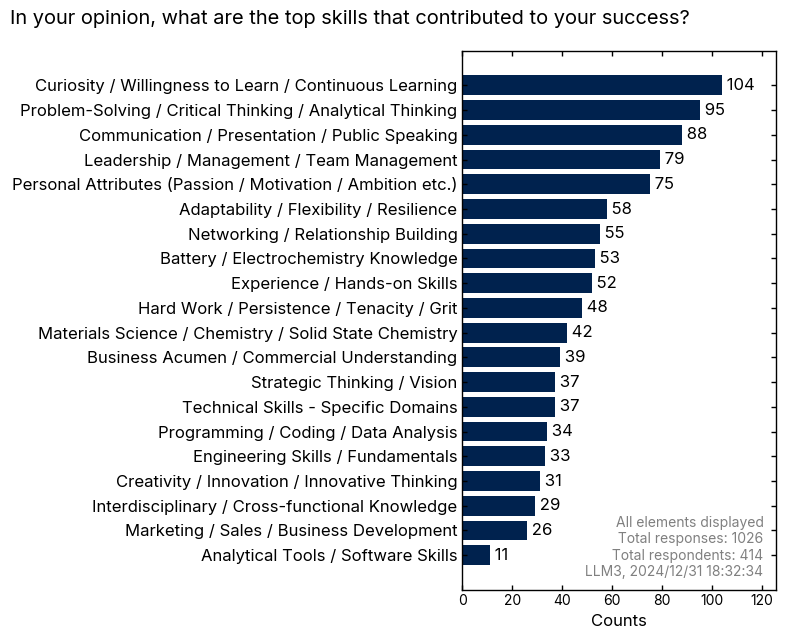

In [16]:
plotter.make_bar_plot_from_dict(counter,
                                title=question['question'],
                                sorted=True,
                                annotation=f'LLM3, {time.strftime("%Y/%m/%d %H:%M:%S")}',
                                num_elements=100,
                                saveas=f'{question['tag']}_recruiters_{time.strftime("%Y%m%d_%H%M%S")}.png'
)